# Homework 3 

In [330]:
import cv2
import numpy as np

import matplotlib.pyplot as plt

In [331]:
def plot_one_image(image: np.ndarray) -> None:
    """
    Отобразить изображение с помощью matplotlib.
    Вспомогательная функция.
    
    :param image: изображение для отображения
    :return: None
    """
    
    fig, axs = plt.subplots(1, 1, figsize=(10, 10))
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs.imshow(image)
    axs.axis('off')
    plt.plot()

# Задача №1 - Лес или пустыня?

Часто при анализе изображений местности необходимо понять ее характер. В частности, если определить, что на изображении преобладет вода, то имеет смысл искать корабли на таком изображении. Если на картинке густой лес, то, возможно, это не лучшая зона для посадки дрона или беспилотника.

Ваша задача - написать программу, которая будет отличать лес от пустыни. В приложении можно найти реальные спутниковые снимки лесов и пустынь.

Примеры изображений:
<table><tr>
    <td> <img src="https://i.ibb.co/nmHHctW/test_image_00.jpg" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="https://i.ibb.co/dM77C4b/test_image_06.jpg" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [339]:
def desert_or_forest(r):
    for i in range(r):
        a='0'+str(i) if i<10 else str(i)
        image = cv2.imread('desert_forest/test_image_'+a+'.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        color = ('r', 'g', 'b')
        l = []
        for i,col in enumerate(color):
            hist_full = cv2.calcHist([image], [i], None, [256], [0,256])
            idx,val = max(enumerate(hist_full),key=operator.itemgetter(1))
            if float(val) > 5000 and idx > 100:
                l.append('desert')
            else:
                l.append('forest')
        print('desert') if l.count('desert') > l.count('forest') else print('forest')

In [343]:
desert_or_forest(20)

forest
forest
forest
forest
desert
forest
desert
forest
forest
forest
desert
desert
desert
desert
desert
desert
desert
forest
forest
desert


# Задача №2 - Раздели объекты в шуме

Дано зашумленное изображение с 3 объектами: круг, треугольник и фон. Треубется выдлеить каждый объект, фон, круг и треугольник в бинарные маски. То есть треубется найти геометрическое место каждого объекта на изображении. Незашумленное изображение приведено __только__ для оценки качества решения. Запрещено использовать любую инофрмацию о незашумленном изоьражении в решении. 

Придумайте способ численной оценки качества полученного результата.

<table><tr>
    <td> <img src="segmentation/gt.png" alt="Drawing" style="width: 200px;"/> </td>
    <td> <img src="segmentation/noise.png" alt="Drawing" style="width: 200px;"/> </td>
</tr></table>

In [136]:
# Ваш код

# Задача №3 - Найди клетки

Даны снимки раковых клеток. Существует задача - определить стадию рака клетки по такому изображению. Для того, чтобы подойти к решению классификации рака клетки, необходимо сначала подготовить данные.

Исходные изображения в реальных задачах могут быть очень большого размера (более 20000 px). Однако из визуального анализа можно заметить, что большая часть этих снимков пустая и не несет в себе полезную информацию.

Ваша задача выделить небольшие ячейки изображений из исходного так, чтобы на ячейках было только изображение клетки.

Пример исходного изображения и нарезанных ячеек клетки.
<img src="../img/cell_example.png" alt="Drawing" style="width: 500px;"/>

В качестве аргументов у функции будут значения:
1. исходное изображние;
2. размер ячейки;
3. количество ячеек.

__Доп вопрос__ - как можно выяснить какие нужны значения аргументов, чтобы они подходили для большинства исходных снимков?

In [137]:
#реализация с помощью квадродерева

In [192]:
class Node():
    def __init__(self, mid, a, parent):
        self.mid = mid#лист с координатами центра
        self.a = a#половина стороны квадрата
        self.state = 0# 0 - нет ничего, 1 - разделён на квадранты 
        
        self.parent = parent
        self.childrens = []
        self.iscell = False
        
    #устанавливаем детей для узла
    def set_childrens(self, parent):
        mid = self.mid
        r = self.a
        
        self.childrens.append(Node([mid[0]+r/2,mid[1]+r/2],r/2,parent))
        self.childrens.append(Node([mid[0]-r/2,mid[1]+r/2],r/2,parent))
        self.childrens.append(Node([mid[0]+r/2,mid[1]-r/2],r/2,parent))
        self.childrens.append(Node([mid[0]-r/2,mid[1]-r/2],r/2,parent))

In [193]:
class QuadTree():
    def __init__(self, coord, image, cellsize):
        self.xmin = coord[0]
        self.ymin = coord[1]
        self.xmax = coord[2]
        self.ymax = coord[3]
        
        self.border = [248,248,248]
        
        fig = plt.figure(figsize = [8,8])
        
        self.acc = cellsize
        
        self.image = image
        
        #минимальная сторона дочернего куба дерева
        self.min_side = (self.xmax-self.xmin)/self.acc
        
        #родительский узел
        self.Root = Node([(self.xmax+self.xmin)/2,(self.ymax+self.ymin)/2],(self.xmax-self.xmin)/2,0)
        self.Root.set_childrens(self.Root)
        self.Root.state = 1
        
        self.add_node(self.Root)
        self.draw_squares(self.Root)
        plot_one_image(self.image)
        cv2.imwrite("cells_/train1_1.jpeg",self.image)
    
    #отрисовка дерева
    def draw_squares(self,child):
        ymin = child.mid[1]-child.a
        ymax = child.mid[1]+child.a
        xmin = child.mid[0]-child.a
        xmax = child.mid[0]+child.a
        img = self.image[int(ymin):int(ymax),int(xmin):int(xmax)]
        if child.state == 1:
            for c in child.childrens:
                self.draw_squares(c)
        elif self.iscell(img):
            cv2.rectangle(self.image, pt1=(int(child.mid[0]-child.a),int(child.mid[1]-child.a)),
                         pt2=(int(child.mid[0]+child.a),int(child.mid[1]+child.a)),
                         color = (0,0,0),thickness=1)
    
    #смотрим какой цвет в данной ячейке и если он не белый, то см на Node в дереве
    def compare(self,image):
        img = []
        for i in image:
            im = np.unique(i,axis=0)
            img.extend(list(im))
        img = np.unique(img,axis=0)
        if len(img) == 1:
            return False
        for i in img:
            if i[0] >= self.border[0] and i[1] >= self.border[1] and i[2] >= self.border[2]:
                return True
        return False
    
    def iscell(self,image):
        img = []
        for i in image:
            im = np.unique(i,axis=0)
            img.extend(list(im))
        img = np.unique(img,axis=0)
        for i in img:
            if i[0] < self.border[0] or i[1] < self.border[1] or i[2] < self.border[2]:
                return True
        return False
    
    def add_node(self,Parent):
        for child in Parent.childrens:
            ymin = child.mid[1]-child.a
            ymax = child.mid[1]+child.a
            xmin = child.mid[0]-child.a
            xmax = child.mid[0]+child.a
            img = self.image[int(ymin):int(ymax),int(xmin):int(xmax)]
            comp = self.compare(img)
            if comp and child.a > self.min_side:
                if child.state == 1:
                    self.add_node(child)
                if child.state == 0:
                    child.set_childrens(child)
                    child.state = 1
                    self.add_node(child)
            if comp == False and child.a < self.min_side:
                child.iscell = True

In [196]:
def cells(image, cells, celln):
    height, width, _ = image.shape
    x = height if height > width else width
    y = height if height > width else width
    square = np.zeros((x,y,3), np.uint8)
    square[:,:] = [255,255,255]
    square[int((y-height)/2):int(y-(y-height)/2), int((x-width)/2):int(x-(x-width)/2)] = image
    tree = QuadTree([0,0,square[0].shape[0],square.shape[0]],square,cells)

<Figure size 576x576 with 0 Axes>

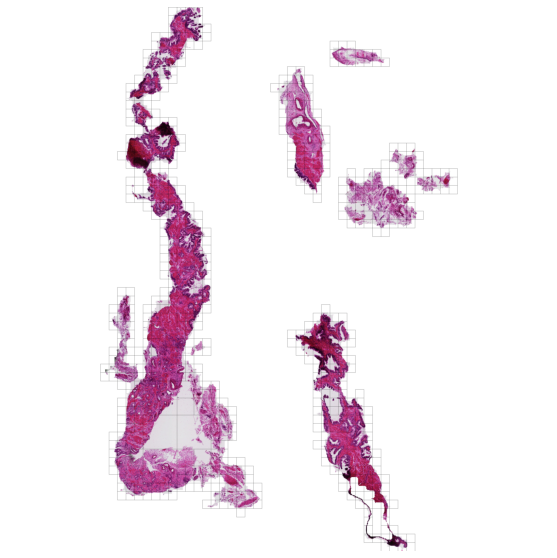

In [199]:
image = cv2.imread('cells/train4_1.jpeg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

cells(image,100,20)